In this post, you will learn how to build your own binary classification model using logistic regression algorithm trained by gradient descent. Logistic regression classification is a type of supervised machine learning, where the algorithm relies on labeled data during training and tries to predict classes during testing. You will apply logistic regression classifier to spam detection, and you can compare this approach to the [naive bayes classifier](http://online.cambridgecoding.com/notebooks/cca_admin/using-your-own-spam-filter-in-real-life). You will use the [spambase](http://mlr.cs.umass.edu/ml/machine-learning-databases/spambase/) dataset from the UCI Machine Learning Repository where most of the attributes indicate whether a particular word or character frequently occurs in a certain type of e-mail. 

On the way, you will learn the theory behind the algorithm in parallel with code implementation. 
The steps you’ll cover in this post can be summarized as follows:
<img class="aligncenter size-thumbnail img-responsive" src="http://s31.postimg.org/iaaxbgc4b/blog5.png" alt="blog5"/>


## Loading and exploring the dataset

You can download the dataset from [here](http://mlr.cs.umass.edu/ml/machine-learning-databases/spambase/). You will need to change the path "spambase/spambase.data" to the folder where you have downloaded the dataset. You can inspect the features and the features names from [spambase.names](http://mlr.cs.umass.edu/ml/machine-learning-databases/spambase/spambase.names) which contains a description of the features extracted as well as some simple statistics over them.

In [15]:
from IPython.external import mathjax; 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import the dataset
data=pd.read_csv("spambase/spambase.data", sep=",",header=None)

This figure illustrates graphically the first e-mail in the dataset. For example, there are 278 capital letters and the word "make" does not occur in this e-mail.
<img class="aligncenter size-thumbnail img-responsive" src="http://s31.postimg.org/5owkrqicb/BLOG4_N.png" alt="blog4"/>


You can examine the dimensions of the dataset using `shape`:

In [16]:
# Exmine the dimensions of the dataset
print (data.shape)
num_observations,num_params = data.shape

(4601, 58)


The Spambase dataset contains 4601 e-mails and 57 different features, with the last column storing the label. In this dataset, the label 0 is used for ham and label 1 for spam. 

Let's split the dataset to X (features) and y (labels).

In [17]:
# Split the dataset to X and y
y=data.iloc[:,-1]
X=data.iloc[:,:-1]

Now let's look at spam vs. ham frequency in the dataset. 

In [18]:
print (y.value_counts())

0    2788
1    1813
dtype: int64


The Spambase data set consists of 4,601 e-mails, 1,813 of which are spam (39.4%). It is always advisable to check the frequency of the labels in your data because if the data is skewed towards one class, your model might not be able to predict both the majority and minority classes well. For example, if you have a dataset with 99% of the data belonging to one class (e.g., it is frequently the case in fraud detection), your model might choose the safest strategy of always predicting the majority class and will not learn anything useful. There are techniques that deal with skewed data which will be covered in one of the next blog posts. Luckily, in this dataset the class ratio is around 60:40 and you don't need to take any action.


## Preprocessing

In general, it's good to explore the data you're working with: you can take a look at one of the previous [tutorials](http://online.cambridgecoding.com/notebooks/cca_admin/eda-and-interactive-figures-with-plotly) which discusses exploratory data analysis.
It is usually advisable to scale your data prior to applying a classification model to avoid attributes with
greater numeric ranges dominating those with smaller numeric ranges. There are many ways of scaling, one common scaling mechanism is to compute z-score where for each
column the values are centered around the mean and divided by their standard deviation. Alternatively you could use [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html) function from sklearn.

In [19]:
# computing z-scores for all variables in X
for i in X:
    X[i] = (X[i] - X[i].mean())/X[i].std()

## Training the classifier

Classification is a broad subject addressed with many different algorithms and optimization techniques. However, the underlying basic process is the same. First of all, you will need a dataset which contains the labels you are trying to predict. The next step is to extract well-defined features from the dataset. When the dataset is ready, you split it into training and test sets and build your classification model using the training set. Next step is to test the classifier on the test set and evaluate the prediction. 

### Introducing the Logistic regression

Let's now look into how Logistic Regression works.

Logistic Regression builds upon the logistic function whose values lie in the range of 0 to 1. <img class="alignleft size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?sigmoid(z)&space;=&space;h(z)=\frac{1}{1&plus;e^{-z}}" alt="blog1"/>



<img class="aligncenter size-thumbnail img-responsive" src="http://s31.postimg.org/fxklbk663/blog1.png" alt="blog1"/>



From the plot you can see that logistic function tends towards 1 as *z* gets bigger, and towards 0 as *z* gets smaller. You can build your own logistic function using the code below:


In [20]:
# Sigmoid function
def sigmoid(z):
    result = 1.0 / (1.0 + np.e**-z)
    return result

A bias feature ($x_0$) of 1 needs to be added to the data. It is common practice in logistic regression to add bias feature, which allows you to shift the entire sigmoid function curve to the right or left to fit the data better.

In [21]:
# np.ones: return a new array of given shape, filled with ones.  
# np.hstack: adds the array filled with ones(np.ones) to the dataframe X. 
X = pd.DataFrame(np.hstack((np.ones((X.shape[0],1)),X)))

### Prediction

Now that you have implemented logistic function let's define logistic regression more formally.
Logistic regression measures the relationship between the categorical dependent variable (spam vs. ham) and one or more independent variables by estimating probabilities using a logistic function.
Logistic regression can be defined as follows:

<img src="https://latex.codecogs.com/gif.latex?p(y=1|\mathbf{x}_j)=h(\mathbf{w}^T&space;\mathbf{x}_j)=&space;\frac{1}{1&plus;e^{-(\mathbf{w}^T&space;\mathbf{x}_j)}}&space;=&space;\frac{1}{1&plus;e^{-(w_0x_0&plus;w_1x_1&plus;w_2x_2&plus;...&plus;w_nx_n)}}" title="p(y=1|\mathbf{x}_j)=h(\mathbf{w}^T \mathbf{x}_j)= \frac{1}{1+e^{-(\mathbf{w}^T \mathbf{x}_j)}} = \frac{1}{1+e^{-(w_0x_0+w_1x_1+w_2x_2+...+w_nx_n)}}" />

where you are predicting how likely it is that a given sample  $\mathbf{x}_j$ belongs to a certain class _y_. In this case  _j_ stands for one observation (e-mail), $\mathbf{w}$ is the weights vector and $\mathbf{x}_j$ are the features for sample *j*. Logistic regression is nothing more than taking a linear combination of $w_0x_0+w_1x_1+w_2x_2+...+w_nx_n$ and transforming it so it can only be between 0 and 1. $w_0$ is the corresponding weight value to the bias term which you added to the dataset above. Certain features, e.g frequency of the word "money" (*word_freq_money*), might be more important for making a decision than other features such as frequency of the word "our" (*word_freq_our*), and the weights vector reflects this by giving the feature *word_freq_money* a higher weight.

In [12]:
# Input x: predictor variables and weights. Output is probability p(y=1|x)
def predict(x_vals,weights):
    return sigmoid(x_vals.dot(weights))

Note that, `dot` product of two vectors $\mathbf{w}$ and $\mathbf{x}_j$ is same as  $w_0x_0+w_1x_1+w_2x_2+...+w_nx_n$

### Logistic regression as a classifier

Since $h(\mathbf{w}^T \mathbf{x}_j)$ outputs a probability, you can apply a threshold of 0.5 so that all the instances with the output values above this threshold will be assigned to class 1 and the ones below the threshold to class 0. 

<img src="https://latex.codecogs.com/gif.latex?prediction_j=\left\{\begin{matrix}&space;1,&space;&&space;if&space;\&space;h(\mathbf{w^T&space;x}_j)&space;\geq&space;0.5&space;,&space;\\&space;0,&space;&&space;if&space;\&space;h(\mathbf{w^T&space;x}_j)&space;<&space;0.5&space;\end{matrix}\right." title="prediction_j=\left\{\begin{matrix} 1, & if \ h(\mathbf{w^T x}_j) \geq 0.5 , \\ 0, & if \ h(\mathbf{w^T x}_j) < 0.5 \end{matrix}\right." />

The goal now is to find the values that minimize the weights ($\mathbf{w}$) so that the model will classify the data correctly with high accuracy. 
A popular and easy-to-use technique to calculate the parameters is to minimize a model’s error (MSE) with Stochastic Gradient Descent. The [Stochastic Gradient Descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) optimization is particularly useful when the number of samples (and the number of features) is very large. Other optimization methods that are often used are [Limited-memory_BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) and [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization).

### Cost function: MSE

The Gradient Descent is method to estimate the weights of the model in many iterations by minimizing a cost function at every step. In this case, mean square error (MSE) is chosen as a cost function:

<img src="https://latex.codecogs.com/gif.latex?MSE=\frac{1}{2m}\sum_{i=0}^{m}(h(\mathbf{w}^T&space;\mathbf{x})-\mathbf{y})^2" title="MSE=\frac{1}{2m}\sum_{i=0}^{m}(h(\mathbf{w}^T \mathbf{x})-\mathbf{y})^2" />
* _Cost function_ is a function where the goal is to minimize the cost value, in this case the cost value is the mean square error.

Let's implement the cost function for logistic regression, which uses the predictor variables *x_vals*, the variable to be predicted *y_vals*, the current model parameters *weights* as input, and outputs the mean square error (MSE). 

In [13]:
def cost_function(x_vals, y_vals, weights):
    n = y_vals.size
    prediction = sigmoid(x_vals.dot(weights))
    error = prediction - y_vals
    try:
        cost = (1.0/(2.0*n)) * error.T.dot(error)  # if array of errors. T = transpose.
    except AttributeError:
        cost = (1.0/(2.0*n)) * error ** 2.0  # if single error value
    return cost


The diagram below summarizes the steps of the logistic regression classifier.
<img class="alignleft size-thumbnail img-responsive" src="http://s31.postimg.org/mb1d9etzv/blog3.png" alt="blog3"/>

In the diagram above, step 1 is to calculate the linear combination of the features and the weights $w_0x_0+w_1x_1+w_2x_2+...+w_nx_n$. You will need to initialize the weights ($\mathbf{w}$) in the first step, where the weights are usually set to zero. Step 2 is to put the linear combination through the sigmoid function, which will output a probability. Now before you make final prediction you want the classifier to be confident that the weight vector indicates which features have greater contribution to the predicted variable and which features are less important for predicting whether e-mail is spam or ham. Therefore, in step 4 you ask the gradient descent to update the weights of the model by minimizing the cost function (MSE). Steps 1, 2, 3 and 4 is repeated until the MSE value doesn't change (with relative tolerance) between iterations. If the difference is within an acceptable range you have reached convergence. Finally, in step 5 the weights have been optimized and you are ready to make prediction, whether an email is spam or ham.

### Gradient Descent
Next step is to implement the gradient descent. Gradient Descent is a very popular optimization approach since it is intuitive and easy to understand, can easily incorporate additional data and be used with parallel processing.

The logistic function is characterized by being __convex__, where convexity ensures that there are no local minima. It is generally easy to minimize convex functions numerically via optimization methods such as gradient descent. Optimizing non-convex functions, on the contrary, is very hard. Such algorithms may be trapped in so-called “local” minima, which do not correspond to the true minimum value of the cost function. 

Image to the left shows an example of a function that is convex, and image to the right shows an example of a non-convex function.

<img class="aligncenter size-thumbnail img-responsive" src="http://s31.postimg.org/94koynwaj/convex.png" alt="blog3"/>


The convex example doesn't contain any local minima. In contrast, non-convex example contains both local and global minima, where the gradient descent might get trapped in the local minima, which will not correspond to the true minimum value.

There are three types of gradient descent: stochastic gradient descent, batch gradient descent and mini-batch gradient descent. The difference is how much data is used to compute the gradient of the cost function. You make a trade-off between the time it takes to update the model and how the accuracy of the parameters updates. 

In this post you will learn how to implement __stochastic gradient descent (SGD)__. Batch gradient descent and mini-batch gradient descent will be covered in one of the next blog posts. SGD runs through each of the data points in the training set sequentially. For each data point, the weights $\mathbf{w}$ are updated, according to the gradient of the
error (*MSE*) with respect to that single training example/observation only. 

<img src="https://latex.codecogs.com/gif.latex?\mathbf{w}_{j&plus;1}&space;:=&space;\mathbf{w}_j&space;-&space;\alpha&space;(&space;h(\mathbf{w}^T&space;\mathbf{x})&space;^{(i)}&space;-&space;\mathbf{y}^{(i)}&space;)\mathbf{x}_j^{(i)}" title="\mathbf{w}_{j+1} := \mathbf{w}_j - \alpha ( h(\mathbf{w}^T \mathbf{x}) ^{(i)} - \mathbf{y}^{(i)} )\mathbf{x}_j^{(i)}" />

where $\mathbf{w}_j$ are the current weights parameters, $\alpha$ is the learning rate and  $(h(\mathbf{w}^T \mathbf{x}) ^{(i)} -  \mathbf{y}^{(i)} )\mathbf{x}_j^{(i)}$ is the equation used to minimize cost function *MSE*.     


Let's give a real life example of how gradient descent works. Imagine, you are standing on a hill and would like to go down as quickly as possible. If you can only see a small part of the terrain around you, what will you do? Probably, the best strategy would be to look around you and find a direction where the slope of the terrain is steepest in the downhill direction. In a next step, you will scan the visible terrain around you again and go in the direction that has the most downhill slope until there is no direction in which you can move downhill. 

The step size you take plays a big role in whether you will move down fast or not. What might happen if you take steps that are too big is that you will overshoot the target location and you will never find your target. At the same time, if you take steps that are too small you are more likely to reach your target point but it might take you ages to go down. Your step size from the example above is the __learning rate__ which in the formula above is denoted with $\alpha$.


Let's implement the __stochastic gradient descent (SGD)__, which takes as input the predictor variables *x_vals*, the variable to be predicted *y_vals*, the step size *learn_rate* and the current model parameters *weights*.

In [14]:
def update(x_vals, y_vals, learn_rate, method, weights):
    preds = predict(x_vals,weights)
    if method == 'SGD':
        g = (preds - y_vals) * x_vals
    weights -= learn_rate * g * (1.0 / y_vals.size)
    return weights

The `update` function updates the weights $\mathbf{w}$ only once, but as mentioned above the gradient descent needs to take many steps to minimize the mean square error *(MSE)*. Before you can glue all the functions together, there is one important step that needs to be introduced, that is cross-validation. 

## Evaluate with cross-validation
To estimate the test error of your learning algorithm, you need to perform [cross-validation](http://online.cambridgecoding.com/notebooks/cca_admin/misleading-modelling-overfitting-crossvalidation-and-the-biasvariance-tradeoff). In k-fold cross-validation, you group your dataset into k-folds, where a model is trained on k-1 of the groups and tested on the remaining group. Each group is used for testing exactly once. The testing error of the classifier is estimated by the average of the performance across all $k$ folds. Now one of the main reasons why you are doing cross validation, is that, when training a model, there is a danger that you can easily overfit to the local noise in your training dataset. You can read more about cross validation in [the previous blog post](http://online.cambridgecoding.com/notebooks/cca_admin/misleading-modelling-overfitting-crossvalidation-and-the-biasvariance-tradeoff). 

The `cross_validate` function glues all the functions you have implemented above together. `cross_validate` starts by splitting the dataset to [k-folds](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html) and initialize the training and test error (*MSE*). The *weights* need to be initialized to zero for every fold. The gradient descent runs `max_epochs` steps, where it updates the *weights* in every step. The MSE train and test error is stored for every step in every fold. The predicted score is stored in a list (`scores_and_labels`) with the true label for all emails that belong to test set for every fold. Finally, you take the average of the *MSE* training and test error over all the folds for every step.

In [11]:
from sklearn.cross_validation import KFold
# evaluating logistic regression model with 10 fold cross validation
def cross_validate(X, y, method='SGD', learn_rate=0.001, max_epochs=30, k_fold=10):
    num_observations,num_params =X.shape
    # Initialise folds and shuffle. 
    kf = KFold(num_observations, n_folds=k_fold, random_state=1,shuffle=True) 
    IndexList = list(kf)
    scores_and_labels = []
    train_error=[]
    test_error=[]
    steps=1
    print 'learning rate: ', learn_rate
    ######################## Cross validation k-fold ########################
    for fold in range(k_fold):
        weights = np.zeros(num_params) #Initialize  the weights
        train_error.append([]) 
        test_error.append([])
        
        #Access first fold indexes for training and testing data.
        train_index, test_index = IndexList[fold]
        train_x, test_x = X.iloc[train_index,:], X.iloc[test_index,:]
        train_y, test_y = y.iloc[train_index], y.iloc[test_index]
        
        # Initial error metrics with default weights
        train_error[fold].append(cost_function(train_x, train_y,weights))
        test_error[fold].append(cost_function(test_x, test_y,weights))
        counter = 0
        while counter < max_epochs:
            counter += 1
            #################stochastic gradient descent ######################
            if method == 'SGD':
                for i in range(len(train_y)):
                    weights = update(train_x.iloc[i], train_y.iloc[i], learn_rate, method, weights)
            else:
                raise AttributeError('Specify gradient descent method as SGD')
            ################# MSE for every fold  ############################
            train_error[fold].append(cost_function(train_x, train_y, weights))
            test_error[fold].append(cost_function(test_x, test_y, weights))
        

        scores_and_labels += [list(i) for i in zip(predict(test_x,weights), test_y)]
    ################# After cross validation  ###################### 
    train_error = np.mean(np.array(train_error), axis=0)
    test_error = np.mean(np.array(test_error), axis=0)
    scores_and_labels = np.array(scores_and_labels)
    
    return train_error , test_error, scores_and_labels, weights

Finally, you can run the code by calling the `cross_validate` function. You set the learning rate of your choice, how many steps (`max_epochs`) you want the gradient descent to take and finally visualize how the training and testing error changes for every step. Since the goal of the gradient descent is to minimize the training error *MSE*, it should decrease with every step until its convergence. 

* Warning - Running this function could take some time -  it depends on how many folds, number of epochs and learning rates you choose. The whole script is attached below, where you can play around with it.

learning rate:  0.1
learning rate:  0.001
learning rate:  0.0001
learning rate:  1e-05


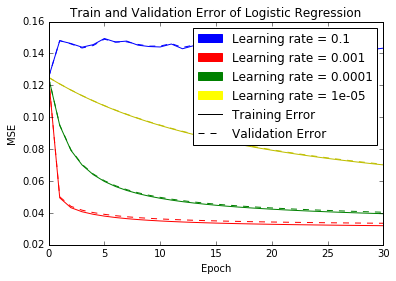

In [14]:
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
def main():
    data=pd.read_csv("spambase/spambase.data", sep=",", header=None)
    
    # Split the dataset to X and y
    y=data.iloc[:,-1]
    X=data.iloc[:,:-1]
    
    #Normalize the data
    for i in X:
        X[i] = (X[i] - X[i].mean())/X[i].std()
    # Add Bias term
    X = pd.DataFrame(np.hstack((np.ones((X.shape[0],1)), X)))

    
    # Choose learning rate
    learn_rate=[0.1,0.001,0.0001, 0.00001]
    # Maximum number of steps
    n_epochs=30
    
    # Plotting settings
    epochs = [i for i in range(n_epochs+1)] #Number of epochs for plotting
    training_style = ['b-', 'r-', 'g-', 'y-']
    test_style = ['b--', 'r--', 'g--','y--']
    
    # Call cross_validate function
    for i in range(0,len(learn_rate)):
        (train_error, test_error, scores_and_labels, weights)=cross_validate(X, y,  method='SGD', learn_rate=learn_rate[i], max_epochs=n_epochs, k_fold=5)
        plt.plot(epochs, train_error, training_style[i], epochs, test_error, test_style[i])
    
    
    plt.title('Train and Validation Error of Logistic Regression' )
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    # Make the plot pretty
    blue = mpatches.Patch(color='blue', label='Learning rate = {}'.format(learn_rate[0]))
    red = mpatches.Patch(color='red', label='Learning rate = {}'.format(learn_rate[1]))
    green = mpatches.Patch(color='green', label='Learning rate = {}'.format(learn_rate[2]))
    yellow = mpatches.Patch(color='yellow', label='Learning rate = {}'.format(learn_rate[3]))
    solid = mlines.Line2D([], [], color='black', label='Training Error')
    dashed = mlines.Line2D([], [], color='black', linestyle='--', label='Validation Error')
    plt.legend(handles=[blue, red, green, yellow, solid, dashed ], numpoints=1)
    plt.show()
    
    
if __name__ == "__main__":
    main()

From the plot you can see that it matters what learning rate you choose. If `learn_rate` is too small, gradient descent can be slow, but if `learn_rate` is too large, gradient descent might overshoot the minimum. In this case `learn_rate=0.001` seems to be the best choice, since it minimizes MSE pretty quickly. On the other hand, `learn_rate=0.1` overshoots the minimum and will never find the target.  You can also assume that the classifier is not overfitting the training data since the *MSE* training error is similar to the *MSE* test error.

To wrap it up, in this post we have covered how to implement logistic regression trained by stochastic gradient descent.
The next steps would be to add [L1 or L2 regularization](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) term to reduce model overfitting and how to choose the best hyperparameters for the model, for which [grid search](http://online.cambridgecoding.com/notebooks/cca_admin/scanning-hyperspace-how-to-tune-machine-learning-models) is often used. There are other methods for evaluating the model, too: for example, you could look into creating a confusion matrix, calculating per-class accuracy, plotting an AUC or ROC curve, or numerous other evaluation metrics.
[`Scikit-learn`](http://scikit-learn.org/stable/) also provides packages for stochastic gradient descent and logistic regression classifier and you could compare your implementation to it.


#### Recap of what you have learned so far:
- The logistic regression is a convex optimization problem. There is only one global optimum for the parameters. 
- Gradient descent is a widely used optimization algorithm, which estimates the weights of the model in many iterations by minimizing a cost function at every step.
- One of the challenges in implementing gradient descent is choosing a good learning rate $\alpha$: if the learning rate is set too low, then gradient descent will converge very slowly; if the learning rate is too high, gradient descent may overshoot the global minima.
- Logistic Regression builds upon the logistic function whose values lie in the range of 0 to 1 and is widely used in binary classification.


    

ABOUT THE AUTHOR

<img class="aligncenter size-thumbnail img-responsive" src="http://s31.postimg.org/lchvjpirf/Agnes_profile.png" alt="Agnes Johannsdottir"/>


Agnes is a master student in Business Analytics at University College London. She studied Management Engineering in Iceland and worked for 2 years as an IT consultant in supply chain. Her main interests lie in using data science methods (especially machine learning) to apply in Retail and Supply Chain businesses.

### Just give me the code:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd

def predict(x_vals, weights):
    return sigmoid(x_vals.dot(weights))

def cost_function(x_vals, y_vals, weights):
    n = y_vals.size
    prediction = sigmoid(x_vals.dot(weights))
    error = prediction - y_vals
    try:
        cost = (1.0/(2.0*n)) * error.T.dot(error)
    except AttributeError:
        cost = (1.0/(2.0*n)) * error ** 2.0
    return cost

def update(x_vals, y_vals, learn_rate, method, weights):
    preds = predict(x_vals,weights)
    if method == 'SGD':
        g = (preds - y_vals) * x_vals
    weights -= learn_rate * g * (1.0 / y_vals.size)
    return weights

def sigmoid( x):
    result = 1.0 / (1.0 + np.e**-x)
    return result

# evaluating logistic regression model with 10 fold cross validation
def cross_validate(X, y, method='SGD', learn_rate=0.001, max_epochs=30, k_fold=10):
    num_observations,num_params =X.shape
    # Initialise folds and shuffle. 
    kf = KFold(num_observations, n_folds=k_fold, random_state=1,shuffle=True) 
    IndexList = list(kf)
    scores_and_labels = []
    train_error=[]
    test_error=[]
    steps=1
    print 'learning rate: ', learn_rate
    ######################## Cross validation k-fold ########################
    for fold in range(k_fold):
        weights = np.zeros(num_params) #Initialize  the weights
        train_error.append([]) 
        test_error.append([])
        
        #Access first fold indexes for training and testing data.
        train_index, test_index = IndexList[fold]
        train_x, test_x = X.iloc[train_index,:], X.iloc[test_index,:]
        train_y, test_y = y.iloc[train_index], y.iloc[test_index]
        
        # Initial error metrics with default weights
        train_error[fold].append(cost_function(train_x, train_y,weights))
        test_error[fold].append(cost_function(test_x, test_y,weights))
        counter = 0
        while counter < max_epochs:
            counter += 1
            #################stochastic gradient descent ######################
            if method == 'SGD':
                for i in range(len(train_y)):
                    weights = update(train_x.iloc[i], train_y.iloc[i], learn_rate, method, weights)
            else:
                raise AttributeError('Specify gradient descent method as SGD')
            ################# MSE for every fold  ############################
            train_error[fold].append(cost_function(train_x, train_y, weights))
            test_error[fold].append(cost_function(test_x, test_y, weights))
        

        scores_and_labels += [list(i) for i in zip(predict(test_x,weights), test_y)]
    ################# After cross validation  ###################### 
    train_error = np.mean(np.array(train_error), axis=0)
    test_error = np.mean(np.array(test_error), axis=0)
    scores_and_labels = np.array(scores_and_labels)
    
    return train_error , test_error, scores_and_labels, weights

def main():
    data=pd.read_csv("spambase/spambase.data", sep=",", header=None)
    
    # Split the dataset to X and y
    y=data.iloc[:,-1]
    X=data.iloc[:,:-1]
    
    #Normalize the data
    for i in X:
        X[i] = (X[i] - X[i].mean())/X[i].std()
    # Add Bias term
    X = pd.DataFrame(np.hstack((np.ones((X.shape[0],1)), X)))

    
    # Choose learning rate
    learn_rate=[0.1,0.001,0.0001, 0.00001]
    # Maximum number of steps
    n_epochs=30
    
    # Plotting settings
    epochs = [i for i in range(n_epochs+1)] #Number of epochs for plotting
    training_style = ['b-', 'r-', 'g-', 'y-']
    test_style = ['b--', 'r--', 'g--','y--']
    
    # Call cross_validate function
    for i in range(0,len(learn_rate)):
        (train_error, test_error, scores_and_labels, weights)=cross_validate(X, y,  method='SGD', learn_rate=learn_rate[i], max_epochs=n_epochs, k_fold=5)
        plt.plot(epochs, train_error, training_style[i], epochs, test_error, test_style[i])
    
    
    plt.title('Train and Validation Error of Logistic Regression' )
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    # Make the plot pretty
    blue = mpatches.Patch(color='blue', label='Learning rate = {}'.format(learn_rate[0]))
    red = mpatches.Patch(color='red', label='Learning rate = {}'.format(learn_rate[1]))
    green = mpatches.Patch(color='green', label='Learning rate = {}'.format(learn_rate[2]))
    yellow = mpatches.Patch(color='yellow', label='Learning rate = {}'.format(learn_rate[3]))
    solid = mlines.Line2D([], [], color='black', label='Training Error')
    dashed = mlines.Line2D([], [], color='black', linestyle='--', label='Validation Error')
    plt.legend(handles=[blue, red, green, yellow, solid, dashed ], numpoints=1)
    plt.show()
    
    
if __name__ == "__main__":
    main()